# Classification and Captioning Aircraft Damage Using Pretrained Models

Project for IBM AI Engineering certification course.

## Modules and Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q \
    pandas \
    tensorflow \
    pillow \
    matplotlib \
    transformers \
    torch \
    torchvision \
    torchaudio \
    roboflow

In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Markdown, display
from google.colab import userdata

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from roboflow import Roboflow

In [5]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Configuration

In [6]:
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

## Dataset

In [7]:
rf = Roboflow(api_key=userdata.get('ROBOFLOW'))
project = rf.workspace("aircraft-damage-ditiction").project("aircraft-damage-detection-2-jgbc6")
version = project.version(3)
dataset = version.download("multiclass")

with open(dataset.location + '/README.dataset.txt', "r") as f:
  content = f.read()
  display(Markdown(content))

loading Roboflow workspace...
loading Roboflow project...


# Aircraft Damage Detection 2 > 2025-09-29 7:21am
https://universe.roboflow.com/aircraft-damage-ditiction/aircraft-damage-detection-2-jgbc6

Provided by a Roboflow user
License: CC BY 4.0



In [8]:
extract_path = dataset.location + '/'

train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

print(train_dir, test_dir, valid_dir, sep='\n')

/content/Aircraft-Damage-Detection-2-3/train
/content/Aircraft-Damage-Detection-2-3/test
/content/Aircraft-Damage-Detection-2-3/valid


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_df = pd.read_csv(train_dir + '/_classes.csv')
test_df = pd.read_csv(test_dir + '/_classes.csv')
valid_df = pd.read_csv(valid_dir + '/_classes.csv')

print('Example columns in df:')
print(train_df.columns)
print()

print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])
print('Valid size: ', valid_df.shape[0])

columns = ['dent', 'crack']
print('\nPossible defects:', columns)

Example columns in df:
Index(['filename', 'crack', 'dent'], dtype='object')

Train size:  3659
Test size:  94
Valid size:  416

Possible defects: ['dent', 'crack']


In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col=columns,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='raw',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_dir,
    x_col='filename',
    y_col=columns,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=columns,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='raw',
    shuffle=False
)

Found 3659 validated image filenames.
Found 416 validated image filenames.
Found 94 validated image filenames.


## Model

I selected VGG16 because its deep convolutional architecture excels at detecting the precise low-level features, such as edges and textures, that define visual defects like cracks and dents. By leveraging transfer learning with this pre-trained model, I can achieve high accuracy on my specific dataset without needing the massive amount of data required to train a network from scratch. Finally, its uniform and well-understood structure makes it straightforward for me to fine-tune the final layers for my specific multi-label classification needs.

### Train

In [12]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_rows, img_cols, 3)
)

In [13]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [14]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [16]:
history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator
)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 59s 309ms/step - accuracy: 0.6692 - loss: 0.5892 - val_accuracy: 0.8317 - val_loss: 0.3615
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8442 - loss: 0.3249 - val_accuracy: 0.8606 - val_loss: 0.3015
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8892 - loss: 0.2244 - val_accuracy: 0.8630 - val_loss: 0.3045
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.9141 - loss: 0.1597 - val_accuracy: 0.8726 - val_loss: 0.2966
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.9240 - loss: 0.1179 - val_accuracy: 0.8462 - val_loss: 0.3484


In [17]:
train_history = model.history.history

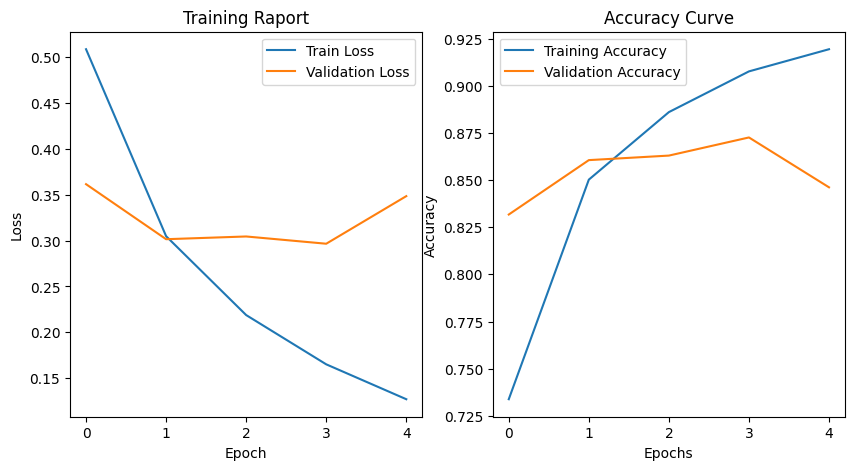

In [18]:
_,axes = plt.subplots(1,2,figsize=(10, 5))

axes[0].set_title("Training Raport")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel('Epoch')
axes[0].plot(train_history['loss'], label='Train Loss')
axes[0].plot(train_history['val_loss'], label='Validation Loss')
axes[0].legend()

axes[1].plot(train_history['accuracy'], label='Training Accuracy')
axes[1].plot(train_history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

### Evaluation

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7604 - loss: 0.8672
Test Loss: 0.8464
Test Accuracy: 0.7656


In [20]:
def get_active_classes_string(label_vector, class_cols):
    active_classes = []
    for i, is_active in enumerate(label_vector):
        if is_active == 1:
            active_classes.append(class_cols[i])

    return ", ".join(active_classes) if active_classes else "None (Clean)"

def plot_image_results(image, true_vector, pred_vector, class_cols):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    true_str = get_active_classes_string(true_vector, class_cols)

    conf_lines = []
    for i, class_name in enumerate(class_cols):
        prob = pred_vector[i]
        conf_lines.append(f"{class_name}: {prob:.4f}")

    conf_str = "\n".join(conf_lines)

    final_title = (f"TRUE CLASS: {true_str}\n"
                   f"----------------\n"
                   f"{conf_str}")

    plt.title(final_title, loc='left', fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.show()

def test_model_on_image(test_generator, model, class_cols, index_to_plot=0):
    test_images, test_labels = next(test_generator)

    predictions = model.predict(test_images)

    img = test_images[index_to_plot]
    true_vector = test_labels[index_to_plot]
    pred_vector = predictions[index_to_plot]

    plot_image_results(img, true_vector, pred_vector, class_cols)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


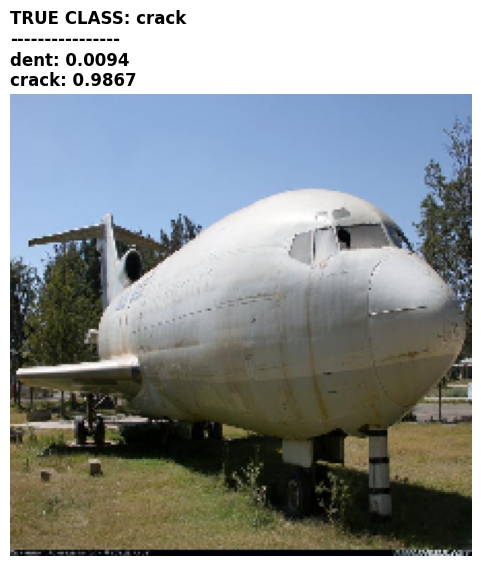

In [21]:
test_model_on_image(
    test_generator=test_generator,
    model=model,
    class_cols=columns,
    index_to_plot=1
)

## Captioning using BLIP

In [22]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [23]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        try:
            image_path_str = image_path.numpy().decode("utf-8")
            image = Image.open(image_path_str).convert("RGB")

            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"
            else:
                prompt = "This is a detailed photo showing plane"

            inputs = self.processor(images=image, text=prompt, return_tensors="pt")
            output = self.model.generate(**inputs)

            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            print(f"Error: {e}")
            return "Error processing image"


In [24]:
def generate_text(image_path, task):
    blip_layer = BlipCaptionSummaryLayer(processor, model)
    return blip_layer(image_path, task)


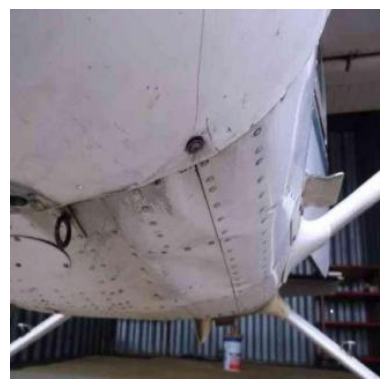

Caption: this is a picture of a plane that has been damaged
Summary: this is a detailed photo showing plane damage


In [25]:
image_url = "/content/Aircraft-Damage-Detection-2-3/test/5_jpg.rf.9fc68a065b54978b8d956a1894866667.jpg"
image_path = tf.constant(image_url)

img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')
plt.show()

caption = generate_text(image_path, tf.constant("caption"))
print("Caption:", caption.numpy().decode("utf-8"))

summary = generate_text(image_path, tf.constant("summary"))
print("Summary:", summary.numpy().decode("utf-8"))